**Objective**: Build an XGBoost model for predicting heart disease and experiment with hyperparameter tuning to improve its performance.

Dataset: [Heart Disease UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

# Task 1: Data Loading and Exploration
1. Load the Heart Disease UCI dataset.
2. Explore the dataset to understand its structure and features.
3. Split the data into training and testing sets.

First and foremost we load the data and check if there's anything strange

In [1]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split

# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 
  
# data (as pandas dataframes) 
X = heart_disease.data.features
y = heart_disease.data.targets

X.head() # First check that all data is roughly ok

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0


Fortunately nothing strange is there- now we check for which data is categorical and which of that is binomial or multinomial. By both counting and looking on the site.

In [2]:
X.nunique() # Check for future one-hot-encoding of categorical

age          41
sex           2
cp            4
trestbps     50
chol        152
fbs           2
restecg       3
thalach      91
exang         2
oldpeak      40
slope         3
ca            4
thal          3
dtype: int64


We can see that `age`, `trestbps`, `chol`, `thalach`, `oldpeak`, and `ca` are continuous/integer variables.
The rest of the variables are categorical, of which `cp`, `restcg`, `slope`, and `thal` are multinomial.

Now we check if anything's missing.

In [3]:
X.isna().sum() # See if something's missing

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
dtype: int64

Taking into account there are so few missing values, we can straight up drop the instances that hold these.

In [4]:
X = X.dropna() # Drop missing stuff
y = y.iloc[X.index]

Last thing before the split, let's check if the dataset is balanced.

In [5]:
counts = []
for i in range(5):
    counts.append(y.query(f"num == {i}").count().item())

print(counts)

[160, 54, 35, 35, 13]


Visibly, the dataset is not balanced- we'll have to deal with that.

Now we just do our split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42) # Split!

# Task 2: Data Preprocessing
1. Handle missing values if any.
2. Encode categorical variables using appropriate methods.
3. Standardize or normalize numerical features if necessary.

Now, let's transform the multinomial variables into one-hot encodings

In [7]:
X_train.loc[:, ["cp", "restecg", "slope", "thal"]] = pd.get_dummies(X_train.loc[:, ["cp", "restecg", "slope", "thal"]])
X_test.loc[:, ["cp", "restecg", "slope", "thal"]] = pd.get_dummies(X_test.loc[:, ["cp", "restecg", "slope", "thal"]])

And check the distributions of the integer features

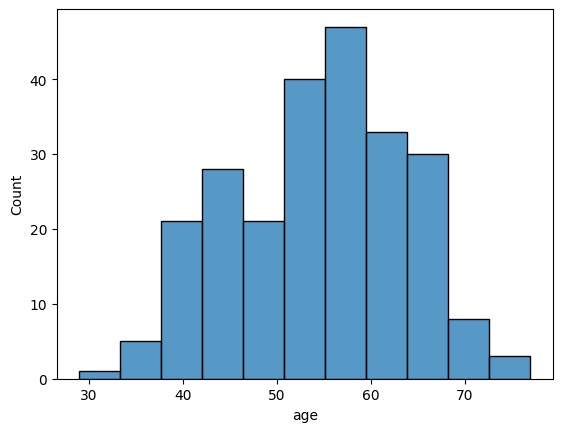

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
#Since we are using an xgboost model there's no need to standardize or normalize! But we'll do it anyway
sns.histplot(X_train, x="age")
plt.show()

Age seems fairly gaussian, we can just execute a z-transform

In [9]:
mu = X_train.age.mean()
std = X_train.age.std()
X_train.age = (X_train.age - mu) / std
X_test.age = (X_test.age - mu) / std

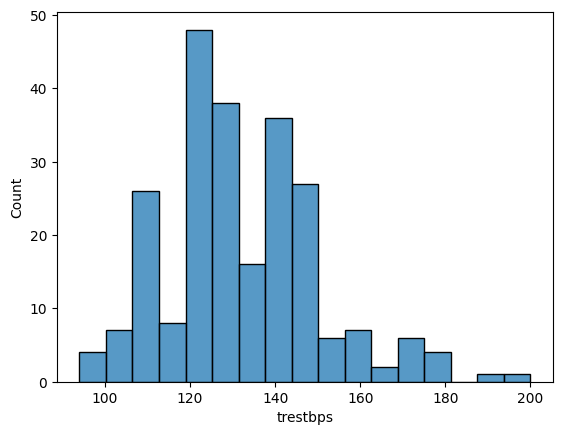

In [10]:
sns.histplot(X_train, x="trestbps")
plt.show()

This seems a bit more skewed, but I still do a simple z-transform

In [11]:
mu = X_train.trestbps.mean()
std = X_train.trestbps.std()
X_train.trestbps = (X_train.trestbps - mu) / std
X_test.trestbps = (X_test.trestbps - mu) / std

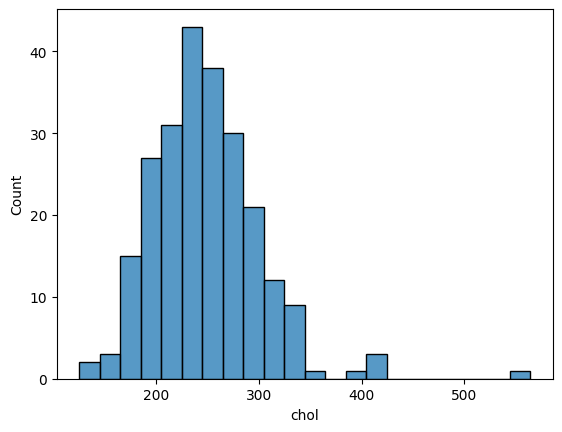

In [12]:
sns.histplot(X_train, x="chol")
plt.show()

Yet again, a bit skewed but no biggie. Z-transform it is.

In [13]:
mu = X_train.chol.mean()
std = X_train.chol.std()
X_train.chol = (X_train.chol - mu) / std
X_test.chol = (X_test.chol - mu) / std

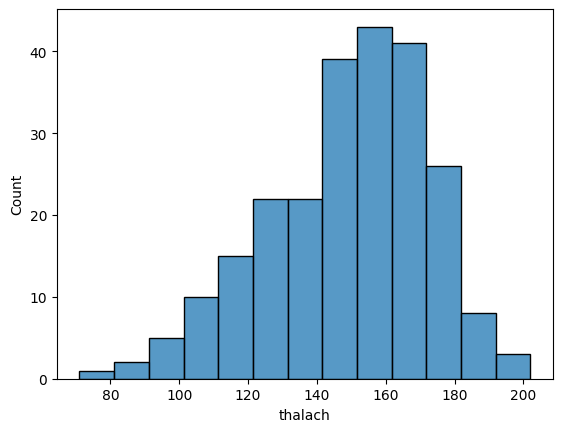

In [14]:
sns.histplot(X_train, x="thalach")
plt.show()

I seriously don't want to do strange base transforms for such small skewedness... Z-Transform.

In [15]:
mu = X_train.thalach.mean()
std = X_train.thalach.std()
X_train.thalach = (X_train.thalach - mu) / std
X_test.thalach = (X_test.thalach - mu) / std

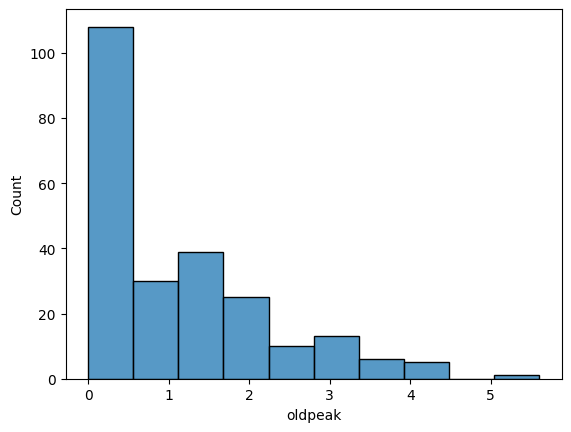

In [16]:
sns.histplot(X_train, x="oldpeak")
plt.show()

Ohhhhh, finally a worthy opponent, let's see whether a square root might put it into a more gaussian-looking distribution.

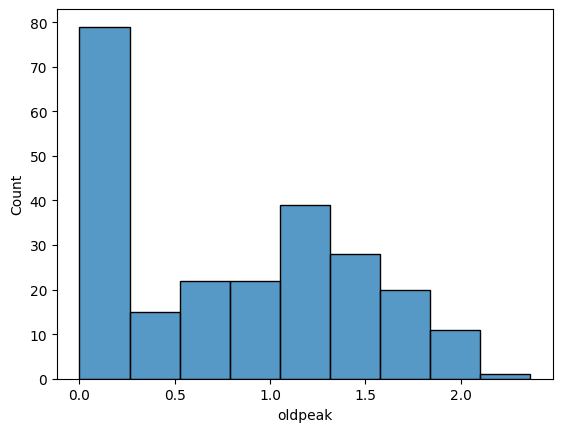

In [17]:
X_train.oldpeak = X_train.oldpeak ** .5

sns.histplot(X_train, x="oldpeak")
plt.show()

That's more like it. We can't do much about the 0 values, if we were to use a log-transform we would have to add some constant and result in a worse situation... therefore I am afraid we must accept the current situation, let's normalize it with a Z-transform now.

In [18]:
mu = X_train.oldpeak.mean()
std = X_train.oldpeak.std()
X_train.oldpeak = (X_train.oldpeak - mu) / std
X_test.oldpeak = (X_test.oldpeak - mu) / std

# Task 3: Initial XGBoost Model
1. Build an initial XGBoost model using default hyperparameters.
2. Train the model on the training set and evaluate its performance on the testing set.
3. Note down the accuracy and any other relevant metrics.

As the dataset is a medical one, and as it is an unbalanced dataset- I'll calculate the accuracy but I'll be looking much more the F1-score, weighted as the dataset is unbalanced.

In [19]:
from sklearn.metrics import f1_score, accuracy_score
import xgboost as xgb

base_model = xgb.XGBClassifier(random_state=42)

base_model.fit(X_train, y_train)

preds = base_model.predict(X_test)

print(f1_score(y_test, preds, average="weighted"))
print(accuracy_score(y_test, preds))

0.6140350877192983
0.6166666666666667


Interestingly enough accuracy and F1 are fairly similar, I'm fairly sure that's just a fluke- the result is far from perfect, let's see if we can manage to make it better!

# Task 4: Hyperparameter Tuning
1. Experiment with hyperparameter tuning to improve model performance.
2. Adjust hyperparameters such as learning_rate, n_estimators, max_depth, etc.
3. Use techniques like cross-validation to find optimal hyperparameters.
4. Train and evaluate the model with the tuned hyperparameters.

In [20]:
from sklearn.model_selection import RandomizedSearchCV # I make the search slightly faster this way!

model = xgb.XGBClassifier(random_state=42)
params = {"n_estimators":[10, 20, 30, 50, 100], "max_depth":[5, 10, 15, 20], "max_leaves":[0, 2, 4, 5, 10, 50, 100], "learning_rate":[1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}
rand_search = RandomizedSearchCV(model, params, scoring="f1_weighted", cv=5, random_state=42)

rand_search.fit(X_train, y_train)
best_model = rand_search.best_estimator_
print(rand_search.best_estimator_.get_params)

preds = best_model.predict(X_test)

print(f1_score(y_test, preds, average="weighted"))
print(accuracy_score(y_test, preds))

<bound method XGBModel.get_params of XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=4,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)>
0.6235240963855422
0.6833333333333333


Automagically (somewhat), the randomized search gives us this fairly better model. Indeed we see how the similarity between the f1 and accuracy that happened in the base model was just a fluke.

We managed to get a bit better on both metrics, and furthermore the randomized search doesn't seem to be taking values on the edges of the given sets, therefore I am pretty sure it would take a lot more to get a better model- I'd say we can feel satisfied like this.

The most interesting thing is how the single models are extremely small, seeing as the chosen amount of maximum leaves is 4.

# Task 5: Feature Importance
1. Explore feature importance using the **feature_importances_** attribute of the trained XGBoost model.
2. Identify the most important features for heart disease prediction.

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

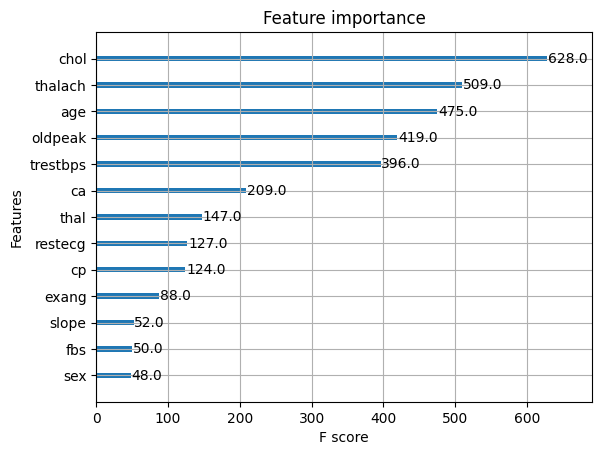

In [21]:
xgb.plot_importance(base_model)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

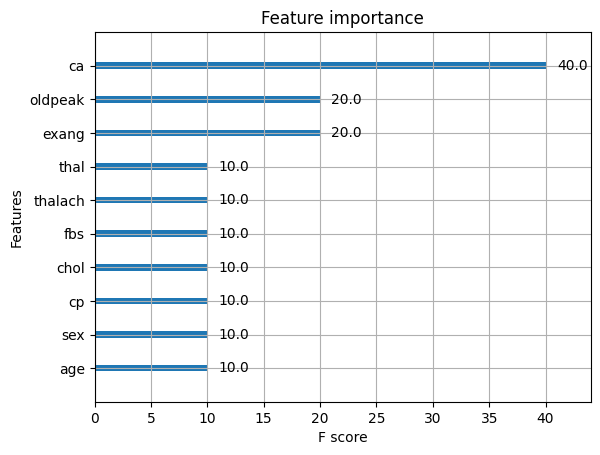

In [22]:
xgb.plot_importance(best_model)

As expected from the maximum number of leaves, the feature importance is wildly different between the two models- we might say that the search gave us a straight-up feature filtering, as some features are completely disregarded in this best model.

# Task 6: Model Evaluation
1. Compare the performance metrics of the initial model and the tuned model.
2. Visualize the improvement achieved in a clear and concise manner.
3. Discuss the impact of hyperparameter tuning and feature importance on model performance.

Given the previous results, the second model is better than the base one- the question is... what's the price?

In [23]:
import time

base_start = time.time_ns()
for _ in range(1000):
    preds = base_model.predict(X_test)
base_end = time.time_ns()

best_start = time.time_ns()
for _ in range(1000):
    preds = best_model.predict(X_test)
best_end = time.time_ns()

print((base_end - base_start) / 1000, (best_end - best_start) / 1000)

3186482.6 2529102.3


We can see how, having a smaller amount of leaves, the best model not only gives better results, but also returns them faster!

Now that we've shown the clear advantages of using the tuned model, what else can we check? My last idea is to see whether the two models make the same prediction errors. To see this, we'll inappropriately use a confusion matrix

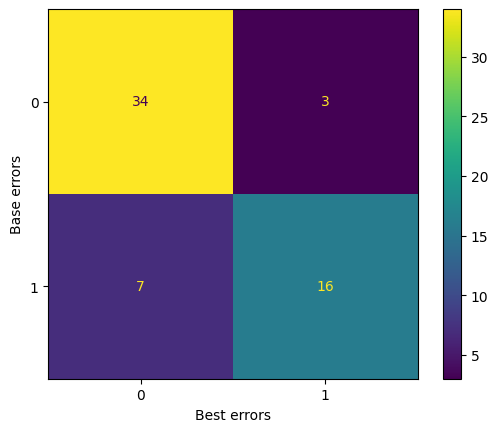

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
base_preds = (base_model.predict(X_test) != y_test.to_numpy()[:, 0])
best_preds = (best_model.predict(X_test) != y_test.to_numpy()[:, 0])

cm = confusion_matrix(base_preds, best_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.ylabel("Base errors")
plt.xlabel("Best errors")
plt.show()

In this improper confusion matrix we can see that, indeed, the best model does 4 errors less than the base model (compute $7-3$).
Nonetheless, $16$ of the instances are erroneously classified by both models, therefore we can expect these $16$ instances to be either erroneously labelled (an improbable but possible thing) or to be simply difficult to classify.

The feature importance shown in the two models says a lot about the dataset- we posit that, probably, the base model is learning some spurious correlations from the training set, and therefore making erroneous classification during the test because of them. Instead, by Occam's razor, we expect the features taken in the tuned model to reflect much more the importance of those features with respect to the task at hand (as the tuned model is much smaller than the base one).

We (I... plurale maiestatis is a thing I do too much nowadays because of reading papers) hope this small set of results was satisfactory, and wish you a good continuation of your work!